# Stats from Goodreads Bookshelf

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
import json

In [2]:
csvPath = os.path.join(".", "goodreads_library_export.csv")

In [3]:
booklist = pd.read_csv(csvPath)

booklist.insert(list(booklist).index("Date Read"), "Year Read", 
                [int(i[:4]) if str(i).find("/") != -1 else -1 for i in booklist["Date Read"]],
                True)
booklist.insert(list(booklist).index("Date Read"), "Month Read", 
                [int(i[5:7]) if str(i).find("/") != -1 else -1 for i in booklist["Date Read"]], 
                True)
booklist.insert(list(booklist).index("Date Read"), "Day Read", 
                [int(i[8:]) if str(i).find("/") != -1 else -1 for i in booklist["Date Read"]], 
                True)

print(booklist.dtypes)


Book Id                         int64
Title                          object
Author                         object
Author l-f                     object
Additional Authors             object
ISBN                           object
ISBN13                         object
My Rating                       int64
Average Rating                float64
Publisher                      object
Binding                        object
Number of Pages               float64
Year Published                float64
Original Publication Year     float64
Year Read                       int64
Month Read                      int64
Day Read                        int64
Date Read                      object
Date Added                     object
Bookshelves                    object
Bookshelves with positions     object
Exclusive Shelf                object
My Review                     float64
Spoiler                       float64
Private Notes                 float64
Read Count                      int64
Owned Copies

### Filtering

In [4]:
read = booklist[booklist["Exclusive Shelf"] == "read"].reset_index(drop=True)
to_read = booklist[booklist["Exclusive Shelf"] == "to-read"].reset_index(drop=True)
reading = booklist[booklist["Exclusive Shelf"] == "currently-reading"].reset_index(drop=True)


# Books by year


Date Read
2021         54
2023         41
2022         37
2020         36
2024         17
Name: count, dtype: int64


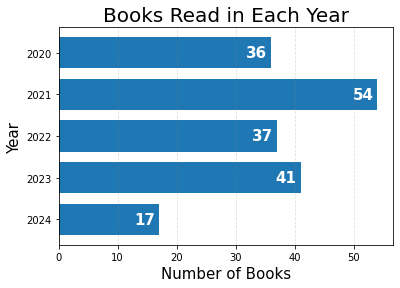

In [5]:
byYearRead = read[["Title","Date Read"]]
byYearRead = byYearRead[byYearRead["Date Read"] == byYearRead["Date Read"]]
byYearRead["Date Read"] = [int(str(x)[0:4]) for x in byYearRead["Date Read"]]
x = np.arange(byYearRead["Date Read"].max(), byYearRead["Date Read"].min()-1,-1)

countMap = byYearRead.value_counts(subset=["Date Read"])

bar_fig, bar_ax = plt.subplots()

bar_ax.set_title("Books Read in Each Year", fontsize=20)
bar_ax.set_xlabel("Number of Books", fontsize=15)
years = [str(i) for i in x]
counts = [countMap[i] for i in x]
print(byYearRead.value_counts(subset=["Date Read"]))

rects = bar_ax.barh(years, counts, align="center", height=0.75)
bar_ax.bar_label(rects, counts, padding=-25, color="white", fontweight="bold", fontsize=15)

bar_ax.xaxis.grid(True, linestyle="--", which="major", color="grey", alpha=0.25)
bar_ax.set_ylabel("Year", fontsize=15)
pass

# General Scatterplot

In [6]:
cols = [i for i in list(booklist) if pd.api.types.is_numeric_dtype(booklist[i])]

listSelection = {
    "read": widgets.Checkbox(
        value=True,
        description="read",
        disabled=False,
        indent=False
    ),
    "toRead": widgets.Checkbox(
        value=False,
        description="to read",
        disabled=False,
        indent=False
    ),
    "continueReading": widgets.Checkbox(
        value=False,
        description="continue reading",
        disabled=False,
        indent=False
    )
}
# selectionBox = widgets.HBox(children=listSelection)

axisChoices = [
    widgets.Dropdown(
        options=cols,
        value=cols[0],
        description="X axis = ",
        disabled=False
    ),
    widgets.Dropdown(
        options=cols,
        value=cols[0],
        description="Y axis = ",
        disabled=False
    ),
]

# axisBox = widgets.VBox(children=axisChoices)

# display(selectionBox)
# display(axisBox)

@widgets.interact(readChoice=listSelection["read"], 
                  toReadChoice=listSelection["toRead"], 
                  continueReadingChoice=listSelection["continueReading"],
                  xAxis=axisChoices[0],
                  yAxis=axisChoices[1])
def on_change(readChoice, toReadChoice, continueReadingChoice, xAxis, yAxis):
    print((readChoice,toReadChoice,continueReadingChoice))
    print(xAxis, yAxis)
    scatter_fig, scatter_plt = plt.subplots()
    
    plotList = []
    if readChoice: plotList.append(read)
    if toReadChoice: plotList.append(to_read)
    if continueReadingChoice: plotList.append(reading)
    if(len(plotList) == 0): plotList.append(booklist)
    chosenList = pd.concat(plotList, ignore_index=True, sort=False)
    
    scatter_plt.scatter(x=chosenList[xAxis], y=chosenList[yAxis])
# outputs = widgets.interact(on_change, read=listSelection["read"])

# for i in listSelection: i.observe(on_change, names="value") 

interactive(children=(Checkbox(value=True, description='read', indent=False), Checkbox(value=False, descriptio…

In [7]:

histchoice = widgets.Dropdown(
        options=cols,
        value=cols[0],
        description="Value = ",
        disabled=False
    )

binSlider = widgets.IntSlider(
    value=7,
    min=3,
    max=100,
    step=1,
    description='Bin Count:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

@widgets.interact(readChoice=listSelection["read"], 
                  toReadChoice=listSelection["toRead"], 
                  continueReadingChoice=listSelection["continueReading"],
                  histChoice=histchoice,
                  binCount=binSlider)
def process_hist_choice(readChoice, toReadChoice, continueReadingChoice, histChoice, binCount):
    hist_fig, hist_plt = plt.subplots()
    
    plotList = []
    if readChoice: plotList.append(read)
    if toReadChoice: plotList.append(to_read)
    if continueReadingChoice: plotList.append(reading)
    if(len(plotList) == 0): plotList.append(booklist)
    chosenList = pd.concat(plotList, ignore_index=True, sort=False)
    
    hist_plt.hist([i for i in chosenList[histChoice] if i != -1], binCount)

interactive(children=(Checkbox(value=True, description='read', indent=False), Checkbox(value=False, descriptio…

## Using WikiData

In [8]:
import requests

def access_wikidata(query, search=True):
    endpoint = "https://www.wikidata.org/w/api.php"
    if search: 
        params = {
            "action": "wbsearchentities",
            "format": "json",
            "search": query,
            "language": "en"
        }
    else:
        params = {
            "action": "wbgetentities",
            "ids": query,
            "format": "json",
            "languages": "en"
        }
    try:
        return requests.get(endpoint, params=params)
    except:
        return "Error"

In [9]:
# test
data = access_wikidata("JRR Tolkien").json()
access_wikidata(data["search"][0]["id"], search=False).json()["entities"]["Q892"]["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]

'Q6581097'

In [10]:

def getGender(name):
    searchResults = access_wikidata(name)
    try: 
        searchResults = searchResults.json()
        firstResultPage = access_wikidata(searchResults["search"][0]["id"], search=False).json()
        gender = firstResultPage["entities"][searchResults["search"][0]["id"]]["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]
        gender = access_wikidata(gender, search=False).json()
        gender = gender["entities"][next(iter(gender["entities"]))]["labels"]["en"]["value"]
        return gender
    except: 
        return "Error"

print("Starting...")
uniqueAuthor = {}
for i in read["Author"]:
    i = " ".join(i.split())
    if i in uniqueAuthor: continue
    currGen = getGender(i)
    print("%-*s %s" % (30, f"\"{i}\":", currGen))
    uniqueAuthor[i] = currGen
    
print("Done.")

Starting...
"Anne Carson":                 female
"Chuck Tingle":                transgender
"Ryka Aoki":                   trans woman
"Leslie Feinberg":             transgender
"Ryoko Kui":                   female
"Mark Z. Danielewski":         male
"Katsuhiro Otomo":             male
"Terry Pratchett":             male
"Melanie Gillman":             non-binary
"Donna Tartt":                 female
"Madeline Miller":             female
"Becky Chambers":              female
"T.J. Klune":                  male
"James Baldwin":               male
"André Aciman":                male
"Taylor Jenkins Reid":         female
"Erin Morgenstern":            female
"Amal El-Mohtar":              female
"Audre Lorde":                 female
"Heinz Heger":                 male
"Casey McQuiston":             non-binary
"Hanya Yanagihara":            female
"Cam Marshall":                Error
"Ocean Vuong":                 male
"Matt Bors":                   male
"N.D. Stevenson":              tra

Author Gender
{'female': 41, 'male': 102, 'transgender': 2, 'trans woman': 1, 'non-binary': 3, 'Error': 7, 'transmasculine': 1}


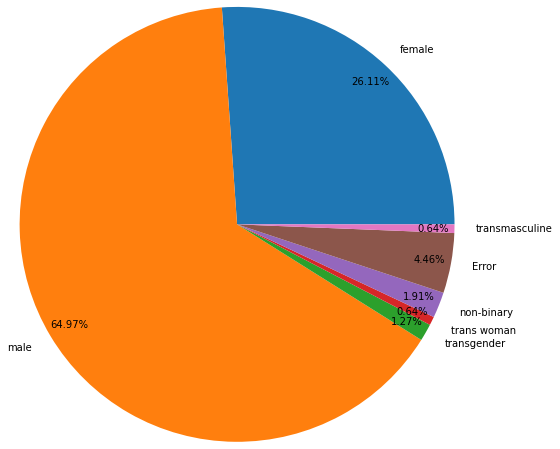

In [11]:
genderCounts = {}
genderCounts["female"] = 0
genderCounts["male"] = 0
for i in uniqueAuthor:
    if uniqueAuthor[i] not in genderCounts:
        genderCounts[uniqueAuthor[i]] = 0
    genderCounts[uniqueAuthor[i]] += 1
    

pie_fig, pie_plt = plt.subplots()


pie_plt.pie([genderCounts[i] for i in genderCounts], 
            labels=list(genderCounts), 
            radius=2.5, 
            autopct = lambda p : str(round(p, 2)) + "%",
            pctdistance = 0.9)

print("Author Gender")
print(genderCounts)

## General

In [12]:
uniqueAuthor = {}
for i in read["Author"]:
    i = " ".join(i.split())
    if i in uniqueAuthor: continue
    uniqueAuthor[i] = "gender"

authorInfo = {}
print("Fetching author info")
for author in uniqueAuthor:
    try:
        print(f"Attempting {author}... ", end="")
        search_results = access_wikidata(author).json()
        top_result = access_wikidata(search_results["search"][0]["id"], search=False).json()
        authorInfo[author] = top_result
        print("Done.")
    except: 
        authorInfo[author] = "Failed"
        print("Failed")
        
print("Done fetching")

Fetching author info
Attempting Anne Carson... Done.
Attempting Chuck Tingle... Done.
Attempting Ryka Aoki... Done.
Attempting Leslie Feinberg... Done.
Attempting Ryoko Kui... Done.
Attempting Mark Z. Danielewski... Done.
Attempting Katsuhiro Otomo... Done.
Attempting Terry Pratchett... Done.
Attempting Melanie Gillman... Done.
Attempting Donna Tartt... Done.
Attempting Madeline Miller... Done.
Attempting Becky Chambers... Done.
Attempting T.J. Klune... Done.
Attempting James Baldwin... Done.
Attempting André Aciman... Done.
Attempting Taylor Jenkins Reid... Done.
Attempting Erin Morgenstern... Done.
Attempting Amal El-Mohtar... Done.
Attempting Audre Lorde... Done.
Attempting Heinz Heger... Done.
Attempting Casey McQuiston... Done.
Attempting Hanya Yanagihara... Done.
Attempting Cam Marshall... Failed
Attempting Ocean Vuong... Done.
Attempting Matt Bors... Done.
Attempting N.D. Stevenson... Done.
Attempting Maia Kobabe... Done.
Attempting Scarlett Gale... Failed
Attempting Naomi Tucke

In [13]:
authorInfo["Becky Chambers"]

{'entities': {'Q25298820': {'pageid': 27252336,
   'ns': 0,
   'title': 'Q25298820',
   'lastrevid': 2285005196,
   'modified': '2024-12-08T16:23:38Z',
   'type': 'item',
   'id': 'Q25298820',
   'labels': {'en': {'language': 'en', 'value': 'Becky Chambers'}},
   'descriptions': {'en': {'language': 'en', 'value': 'American author'}},
   'aliases': {'en': [{'language': 'en', 'value': 'Rebecca Marie Chambers'}]},
   'claims': {'P31': [{'mainsnak': {'snaktype': 'value',
       'property': 'P31',
       'hash': 'ad7d38a03cdd40cdc373de0dc4e7b7fcbccb31d9',
       'datavalue': {'value': {'entity-type': 'item',
         'numeric-id': 5,
         'id': 'Q5'},
        'type': 'wikibase-entityid'},
       'datatype': 'wikibase-item'},
      'type': 'statement',
      'id': 'Q25298820$5F3A2F33-1AD9-4402-8A14-D728FDA6A906',
      'rank': 'normal',
      'references': [{'hash': '58d0e01666461ada5395ed6c4f0bbc26af612305',
        'snaks': {'P854': [{'snaktype': 'value',
           'property': 'P854',

In [14]:
from functools import cache

@cache
def translateID(id):
    idText = access_wikidata(id, search=False).json()
    return idText["entities"][next(iter(idText["entities"]))]["labels"]["en"]["value"]

def unpackWikidata(pageJson):
    if(pageJson == "Failed"): return "Failed"
    
    data = {}
    properties = pageJson["entities"][list(pageJson["entities"])[0]]["claims"]
    for i in properties:
#         s = json.dumps(properties[i])
#         q = json.dumps(json.loads(s), indent=2)
#         print(q)
        try:
            if(properties[i][0]["type"] == "statement"):
                value = properties[i][0]["mainsnak"]["datavalue"]["value"]
                if isinstance(value, str):
                    data[translateID(i)] = value
                else:
                    data[translateID(i)] = translateID(value["id"])
        except:
            pass
            
    return data
            
    
#     for id in list(spot):
#         print(translateID(id))

In [15]:
unpackedData = {}
for i in authorInfo:
    print(i)
    unpackedData[i] = unpackWikidata(authorInfo[i])
  

unpackedData

Anne Carson
Chuck Tingle
Ryka Aoki
Leslie Feinberg
Ryoko Kui
Mark Z. Danielewski
Katsuhiro Otomo
Terry Pratchett
Melanie Gillman
Donna Tartt
Madeline Miller
Becky Chambers
T.J. Klune
James Baldwin
André Aciman
Taylor Jenkins Reid
Erin Morgenstern
Amal El-Mohtar
Audre Lorde
Heinz Heger
Casey McQuiston
Hanya Yanagihara
Cam Marshall
Ocean Vuong
Matt Bors
N.D. Stevenson
Maia Kobabe
Scarlett Gale
Naomi Tucker
Ray Bradbury
Neil Gaiman
Bryan Lee O'Malley
Rachel Smythe
Keith Giffen
Frank Miller
Sarah Andersen
Matt Ruff
H.P. Lovecraft
Shelley Parker-Chan
Michelle Alexander
Daniel Keyes
Anthony Burgess
Malcolm X
Ernesto Che Guevara
Martha Wells
Ursula K. Le Guin
Robin Wall Kimmerer
Brandon Sanderson
Seanan McGuire
Ibram X. Kendi
Ernest Callenbach
Benjamin Hoff
Randall Munroe
Emily St. John Mandel
Sherman Alexie
Shirley Jackson
Philip K. Dick
Ian Fleming
William Golding
Andy Weir
William Gibson
Alan Weisman
Hermann Hesse
Haruki Murakami
James Riley
Alastair Reynolds
Susanna Clarke
Edward Abbey
Am

{'Anne Carson': {'VIAF ID': '110404294',
  'ISNI': '0000000121476276',
  'instance of': 'human',
  'place of birth': 'Toronto',
  'occupation': 'classical philologist',
  'award received': 'Guggenheim Fellowship',
  'GND ID': '122416309',
  'Library of Congress authority ID': 'n85370220',
  'Freebase ID': '/m/0ljpq',
  'country of citizenship': 'Canada',
  'notable work': 'Autobiography of Red',
  'CANTIC ID (former scheme)': 'a11080905',
  'employer': 'Princeton University',
  'given name': 'Anne',
  'Nationale Thesaurus voor Auteursnamen ID': '07236629X',
  'Perlentaucher ID': 'anne-carson',
  'Digitale Bibliotheek voor de Nederlandse Letteren author ID': 'cars003',
  'family name': 'Carson',
  'FAST ID': '169263',
  'Encyclopædia Britannica Online ID': 'biography/Anne-Carson',
  'member of': 'American Academy of Arts and Sciences',
  'NE.se ID': 'anne-carson',
  'SNAC ARK ID': 'w6qj8321',
  'Quora topic ID': 'Anne-Carson',
  'influenced by': 'Virginia Woolf',
  'National Library of 

In [16]:
unpackedData["Becky Chambers"]

{'instance of': 'human',
 'sex or gender': 'female',
 'occupation': 'science fiction writer',
 'Bibliothèque nationale de France ID': '17074715h',
 'Library of Congress authority ID': 'no2016015279',
 'VIAF ID': '169145541820896600334',
 'image': 'Becky Chambers.jpg',
 'Internet Speculative Fiction Database author ID': '217169',
 'ISNI': '0000000459730147',
 'Nationale Thesaurus voor Auteursnamen ID': '401251837',
 'place of birth': 'Southern California',
 'NooSFere author ID': '2147199065',
 'Commons category': 'Becky Chambers',
 'family name': 'Chambers',
 'Goodreads author ID': '8389735',
 'official website': 'https://www.otherscribbles.com',
 'sexual orientation': 'gay',
 'NL CR AUT ID': 'ola2017972290',
 'languages spoken, written or signed': 'English',
 'genre': 'science fiction',
 'notable work': 'The Long Way to a Small, Angry Planet',
 'nominated for': 'Otherwise Award',
 'Encyclopedia of Science Fiction ID': 'chambers_becky',
 'GND ID': '1128839989',
 'given name': 'Becky',
 

## Country

Author country of citizenship
{'Canada': 5, 'United States of America': 89, 'Japan': 4, 'United Kingdom': 21, 'Austria': 2, 'Failed': 4, 'German Empire': 1, 'Sweden': 1, 'Kingdom of Prussia': 2, 'Iran': 1, 'Colonial Nigeria': 1, 'United Kingdom of Great Britain and Ireland': 5, 'Poland': 1, 'Russian Socialist Federative Soviet Republic': 1, 'Pakistan': 1, 'Ireland': 1, 'Australia': 2, 'France': 1, 'Brazil': 1}


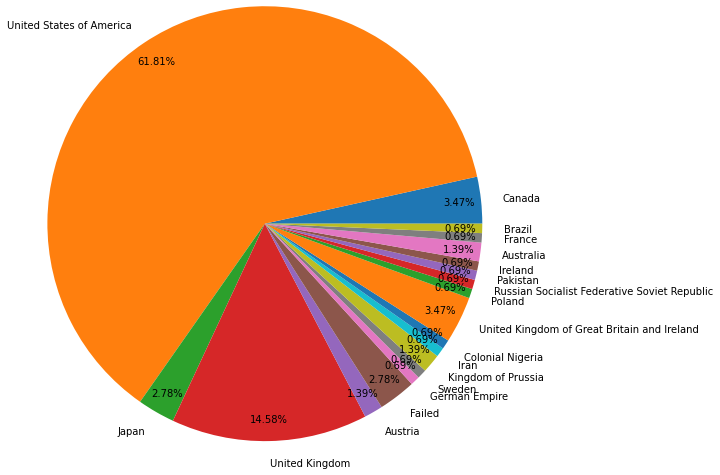

In [17]:
countryCounts = {}
attr = "country of citizenship"

for i in unpackedData:
    if unpackedData[i] == "Failed":
        if "Failed" not in countryCounts:
            countryCounts["Failed"] = 1
        else:
            countryCounts["Failed"] += 1
        continue
#     print(unpackedData[i]["country of citizenship"])
    if attr in unpackedData[i]:
        if unpackedData[i][attr] not in countryCounts: 
            countryCounts[unpackedData[i][attr]] = 1
        else:
            countryCounts[unpackedData[i][attr]] += 1
    

pie_fig, pie_plt = plt.subplots()


pie_plt.pie([countryCounts[i] for i in countryCounts], 
            labels=list(countryCounts), 
            radius=2.5, 
            autopct = lambda p : str(round(p, 2)) + "%",
            pctdistance = 0.9)

print("Author", attr)
print(countryCounts)

## Country of Birth

In [18]:
birthCounts = {}
attr = "place of birth"

for i in unpackedData:
    print(i, end=" ")
    if unpackedData[i] == "Failed":
        if "Failed" not in birthCounts:
            birthCounts["Failed"] = 1
        else:
            birthCounts["Failed"] += 1
        continue
#     print(unpackedData[i]["country of citizenship"])
    if attr in unpackedData[i]:
        try:
#             print(unpackedData[i][attr])
            placeID = access_wikidata(unpackedData[i][attr]).json()["search"][0]["id"]
            print(placeID, unpackedData[i][attr])
            birthCountry = access_wikidata(placeID, search=False).json()
            birthCountry = birthCountry["entities"][list(birthCountry["entities"])[0]]["claims"]
            birthCountry = birthCountry["P17"][0]["mainsnak"]["datavalue"]["value"]["id"]
            birthCountry = translateID(birthCountry)
            print(birthCountry)
            if birthCountry not in birthCounts: 
                birthCounts[birthCountry] = 1
            else:
                birthCounts[birthCountry] += 1
        except:
            if "Failed" not in birthCounts:
                birthCounts["Failed"] = 1
            else:
                birthCounts["Failed"] += 1
    

Anne Carson Q172 Toronto
Canada
Chuck Tingle Q5889125 Home of Truth
United States of America
Ryka Aoki Leslie Feinberg Q41819 Kansas City
United States of America
Ryoko Kui Mark Z. Danielewski Q60 New York City
United States of America
Katsuhiro Otomo Q1238720 Tome
Terry Pratchett Q812906 Beaconsfield
United Kingdom
Melanie Gillman Donna Tartt Q3116159 Greenwood
United States of America
Madeline Miller Q100 Boston
United States of America
Becky Chambers Q844837 Southern California
United States of America
T.J. Klune Q846170 Roseburg
United States of America
James Baldwin Q9286457 Harlem
André Aciman Q88 Alexandria
United States of America
Taylor Jenkins Reid Q21396327 Acton
Erin Morgenstern Q1215860 Marshfield
United Kingdom
Amal El-Mohtar Q1930 Ottawa
Canada
Audre Lorde Q60 New York City
United States of America
Heinz Heger Casey McQuiston Q28218 Baton Rouge
United States of America
Hanya Yanagihara Q65 Los Angeles
United States of America
Cam Marshall Ocean Vuong Q1854 Ho Chi Minh Ci

Author place of birth
{'Canada': 5, 'United States of America': 89, 'Japan': 4, 'United Kingdom': 21, 'Austria': 2, 'Failed': 4, 'German Empire': 1, 'Sweden': 1, 'Kingdom of Prussia': 2, 'Iran': 1, 'Colonial Nigeria': 1, 'United Kingdom of Great Britain and Ireland': 5, 'Poland': 1, 'Russian Socialist Federative Soviet Republic': 1, 'Pakistan': 1, 'Ireland': 1, 'Australia': 2, 'France': 1, 'Brazil': 1}


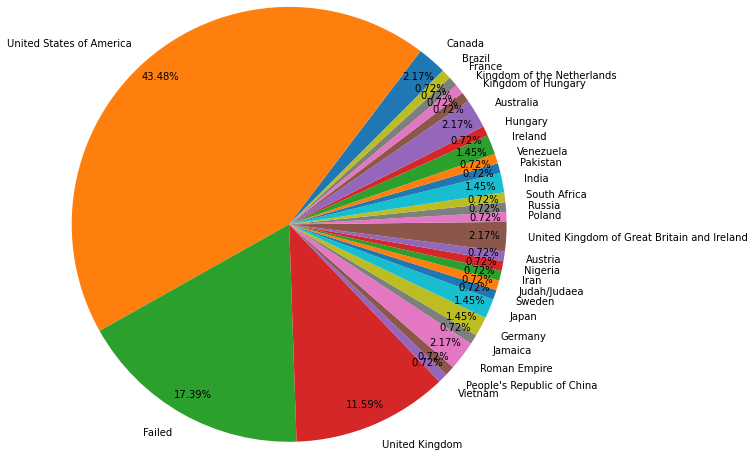

In [19]:
pie_fig, pie_plt = plt.subplots()


pie_plt.pie([birthCounts[i] for i in birthCounts], 
            labels=list(birthCounts), 
            radius=2.5, 
            autopct = lambda p : str(round(p, 2)) + "%",
            pctdistance = 0.9,
            startangle=45)

print("Author", attr)
print(countryCounts)

157
13
Attribute: sexual orientation
{'bisexuality': 3, 'lesbianism': 2, 'gay': 2, 'asexuality': 2, 'Failed': 4, 'homosexuality': 3, 'non-heterosexuality': 1}


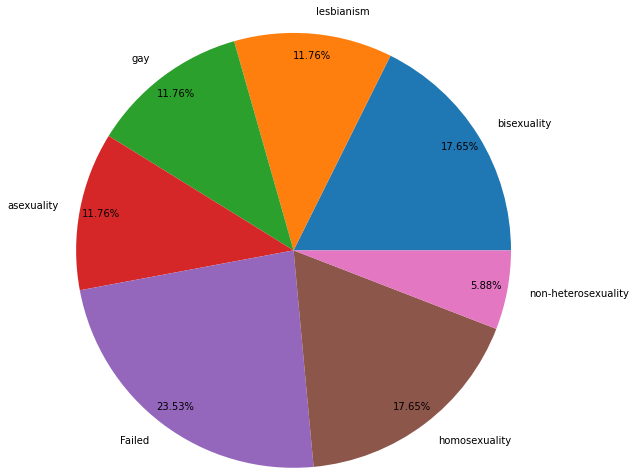

In [25]:
orientationCounts = {}
attr = "sexual orientation"

print(len(unpackedData))
cnt = 0

for i in unpackedData:
    if unpackedData[i] == "Failed":
        if "Failed" not in orientationCounts:
            orientationCounts["Failed"] = 1
        else:
            orientationCounts["Failed"] += 1
        continue
#     print(unpackedData[i]["country of citizenship"])
    if attr in unpackedData[i]:
        cnt += 1
        if unpackedData[i][attr] not in orientationCounts: 
            orientationCounts[unpackedData[i][attr]] = 1
        else:
            orientationCounts[unpackedData[i][attr]] += 1
print(cnt)

pie_fig, pie_plt = plt.subplots()


pie_plt.pie([orientationCounts[i] for i in orientationCounts], 
            labels=list(orientationCounts), 
            radius=2.5, 
            autopct = lambda p : str(round(p, 2)) + "%",
            pctdistance = 0.9)

print("Attribute:", attr)
print(orientationCounts)

# The Books Themselves

In [20]:
bookInfo = {}
for i in read["Title"]:
    if(i.find(":") >= 0):
        i = i[:i.find(":")]
    if(i.find("(") >= 0):
        i = i[:i.find("(")]
    print(i, end="... ")
    try:
        topID = access_wikidata(i).json()["search"][0]["id"]
        bookPage = access_wikidata(topID, search=False).json()
        bookInfo[i] = unpackWikidata(bookPage)
        print("Done.")
    except:
        print("Failed.")
        bookInfo[i] = "Failed"
        
print("Info fetching done.")

Autobiography of Red... Done.
Trans Wizard Harriet Porber and the Bad Boy Parasaurolophus... Failed.
Light from Uncommon Stars... Done.
The Beauty of the Husband... Done.
Stone Butch Blues... Done.
Delicious in Dungeon, Vol. 1... Failed.
House of Leaves... Done.
Akira, Vol. 1... Done.
Reaper Man ... Done.
Other Ever Afters... Failed.
The Secret History... Done.
The Song of Achilles... Done.
The Long Way to a Small, Angry Planet ... Done.
The House in the Cerulean Sea ... Done.
Giovanni’s Room... Done.
Call Me by Your Name... Done.
Under the Whispering Door... Done.
The Seven Husbands of Evelyn Hugo... Done.
A Psalm for the Wild-Built ... Done.
The Starless Sea... Done.
To Be Taught, If Fortunate... Done.
A Prayer for the Crown-Shy ... Done.
This Is How You Lose the Time War... Done.
Zami... Done.
The Men with the Pink Triangle... Done.
One Last Stop... Done.
A Little Life... Done.
Matchmaker... Done.
Red, White & Royal Blue... Done.
Red Doc>... Done.
On Earth We're Briefly Gorgeous... 

The Outcast ... Done.
The Caves of Steel ... Done.
The Horse and His Boy ... Done.
The Magician's Nephew ... Done.
Leven Thumps and the Gateway to Foo ... Done.
A World Without Heroes ... Done.
The Battlemage ... Failed.
The Inquisition ... Done.
The Novice ... Done.
The Return of the King ... Done.
The Two Towers ... Done.
The Greatest War Stories Never Told... Failed.
The Greatest Presidential Stories Never Told... Failed.
The Greatest Stories Never Told... Done.
Inheritance, Or, The Vault Of Souls ... Done.
Brisingr ... Done.
The Royal Ranger ... Done.
The Lost Stories ... Done.
The Emperor of Nihon-Ja ... Done.
Halt's Peril ... Done.
The Kings of Clonmel ... Done.
Erak's Ransom ... Done.
The Siege of Macindaw ... Done.
The Sorcerer of the North ... Done.
Ranger's Apprentice... Done.
The Icebound Land ... Done.
The Burning Bridge... Done.
The Ruins of Gorlan ... Done.
The Enchantress ... Done.
The Alchemyst ... Done.
Eldest ... Done.
Slaves of Socorro ... Done.
The Hunters ... Done.

In [21]:
genreCounts = {}

for i in bookInfo:
    print(i, end="... ")
    if(bookInfo[i] == "Failed"):
        print("Failed.")
        if "Failed" not in genreCounts:
            genreCounts["Failed"] = 1
        else:
            genreCounts["Failed"] += 1
        continue
    try:
        if bookInfo[i]["genre"] not in genreCounts:
            genreCounts[bookInfo[i]["genre"]] = 1
        else:
            genreCoutns[bookInfo[i]["genre"]] += 1
        print("Done.")
    except:
        print("Failed.")
        genreCounts["Failed"] += 1

genreCounts

Autobiography of Red... Done.
Trans Wizard Harriet Porber and the Bad Boy Parasaurolophus... Failed.
Light from Uncommon Stars... Done.
The Beauty of the Husband... Done.
Stone Butch Blues... Failed.
Delicious in Dungeon, Vol. 1... Failed.
House of Leaves... Failed.
Akira, Vol. 1... Failed.
Reaper Man ... Done.
Other Ever Afters... Failed.
The Secret History... Done.
The Song of Achilles... Done.
The Long Way to a Small, Angry Planet ... Failed.
The House in the Cerulean Sea ... Failed.
Giovanni’s Room... Failed.
Call Me by Your Name... Done.
Under the Whispering Door... Failed.
The Seven Husbands of Evelyn Hugo... Done.
A Psalm for the Wild-Built ... Done.
The Starless Sea... Failed.
To Be Taught, If Fortunate... Failed.
A Prayer for the Crown-Shy ... Failed.
This Is How You Lose the Time War... Failed.
Zami... Failed.
The Men with the Pink Triangle... Failed.
One Last Stop... Done.
A Little Life... Failed.
Matchmaker... Failed.
Red, White & Royal Blue... Failed.
Red Doc>... Done.
On 

{'LGBT-related literature': 1,
 'Failed': 241,
 'science fiction': 1,
 'poetry': 1,
 'fantasy': 1,
 'campus novel': 1,
 'historical fiction': 1,
 'LGBT-related film': 1,
 'historical novel': 1,
 'solarpunk': 1,
 'romance': 1,
 'verse novel': 1,
 'graphic memoir': 1,
 'horror fiction': 1,
 'television series based on a novel': 1,
 'progressive rock': 1,
 'non-fiction': 1,
 'epistolary novel': 1,
 'drama film': 1,
 'autobiography': 1,
 'biographical film': 1,
 'bildungsroman': 1,
 'high fantasy': 1,
 'utopian fiction': 1,
 'philosophy': 1,
 'fictional diary': 1,
 'autobiographical novel': 1,
 'spy film': 1,
 'young adult fiction': 1,
 'cyberpunk novel': 1,
 'romance novel': 1,
 'thriller': 1,
 'magic realist fiction': 1,
 'Lies': 1,
 'society and culture podcast': 1,
 'philosophical novel': 1,
 'Gothic literature': 1,
 'political manifesto': 1,
 'fiction literature': 1,
 'detective fiction': 1,
 'essay': 1,
 'Gothic novel': 1,
 'cyberpunk': 1,
 'mirabilia': 1,
 'science fiction film': 1,